In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from basic_model.basic_model import BasicModel
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Setup dataset and dataloader

In [3]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)

Training Setup

In [4]:
BATCH_LEN = 16
EPOCHS = 20

In [5]:
cl_loader = DataLoader(dataset, batch_size=BATCH_LEN)

Create the model

In [6]:
model = BasicModel()
model.to(device)

BasicModel(
  (layer0): Linear(in_features=196608, out_features=512, bias=True)
  (layer1): Linear(in_features=512, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=98304, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Training utilities
# wow

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

Training loop definition

In [8]:
dir_to_save = 'basic_models'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [9]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch):
    its_til_checkpoint = 2
    
    running_loss = 0
    count = 0
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i == 64:
            break
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')
            losses.append(curr_loss)

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))

            running_loss = 0
            count = 0
    
    losses.append(running_loss / count)

In [ ]:
losses = []
train_epoch(cl_loader, model, optimizer, criterion, losses, 0)

In [10]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    for epoch in range(epochs):
        print(f'Entering epoch {epoch}')
        train_epoch(dataloader, model, optimizer, criterion, losses, epoch)
    
    return losses

In [11]:
model = BasicModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

Entering epoch 0
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.2559818625450134


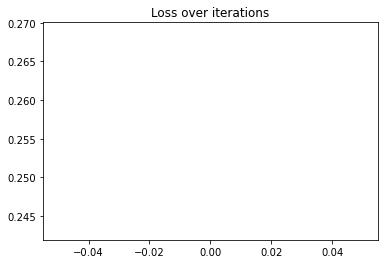

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.2684154510498047


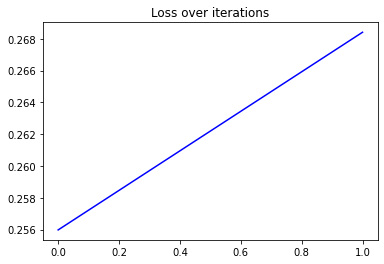

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.20882412791252136


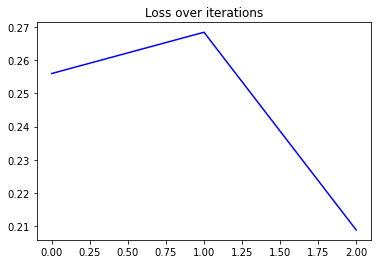

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.18949288129806519


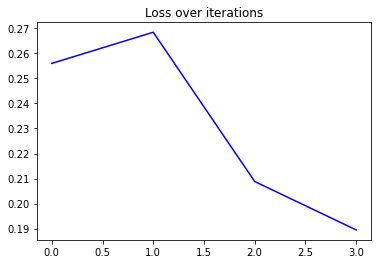

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.2535673677921295


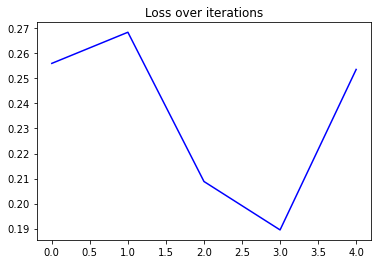

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.2550601065158844


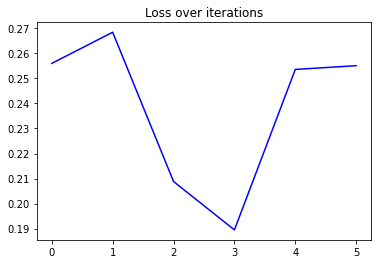

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.2231954038143158


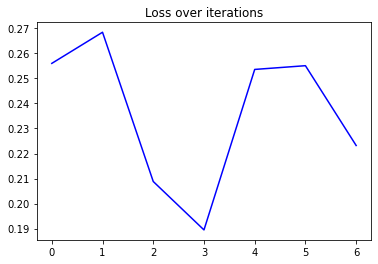

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.23381957411766052


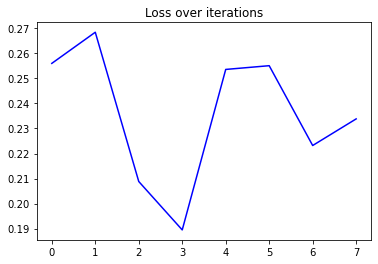

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.21982237696647644


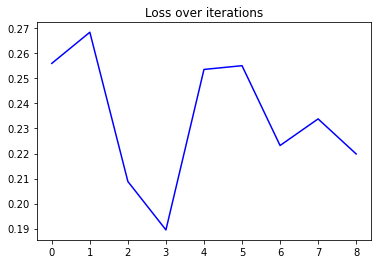

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.20089560747146606


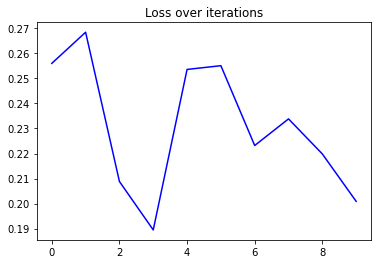

Iteration 20 - batch size: 16
Iteration 21 - batch size: 16
Current loss after 2 iterations: 0.16745436191558838


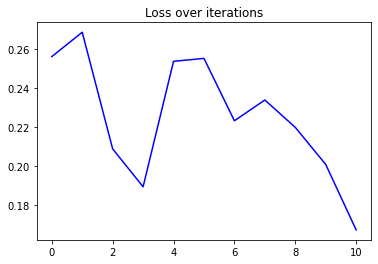

Iteration 22 - batch size: 16
Iteration 23 - batch size: 16
Current loss after 2 iterations: 0.21776315569877625


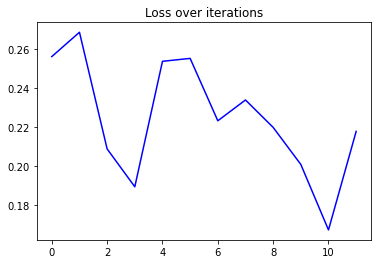

Iteration 24 - batch size: 16
Iteration 25 - batch size: 16
Current loss after 2 iterations: 0.3224862813949585


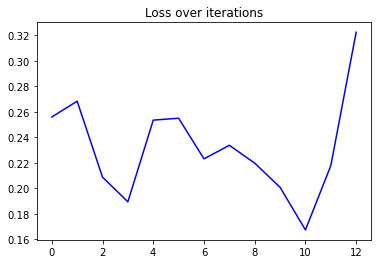

Iteration 26 - batch size: 16
Iteration 27 - batch size: 16
Current loss after 2 iterations: 0.3112020492553711


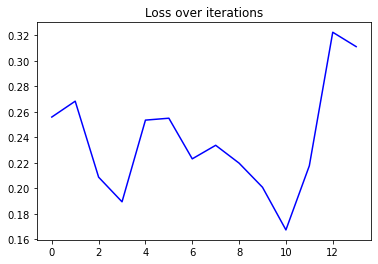

Iteration 28 - batch size: 16
Iteration 29 - batch size: 16
Current loss after 2 iterations: 0.2876852750778198


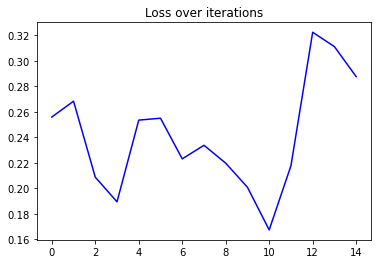

Iteration 30 - batch size: 16
Iteration 31 - batch size: 16
Current loss after 2 iterations: 0.22681328654289246


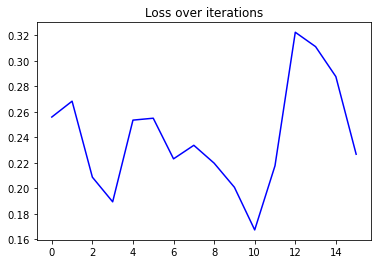

Iteration 32 - batch size: 16
Iteration 33 - batch size: 16
Current loss after 2 iterations: 0.25577571988105774


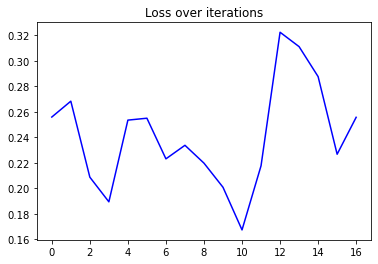

Iteration 34 - batch size: 16
Iteration 35 - batch size: 16
Current loss after 2 iterations: 0.20354408025741577


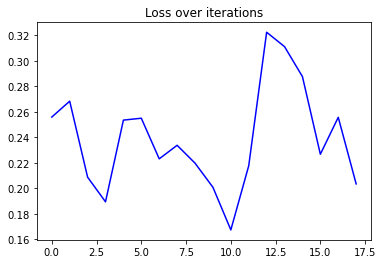

Iteration 36 - batch size: 16
Iteration 37 - batch size: 16
Current loss after 2 iterations: 0.2154574990272522


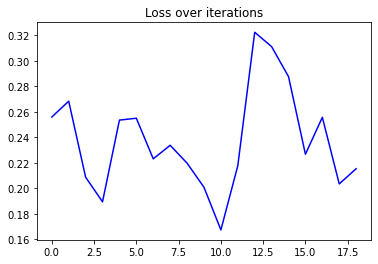

Iteration 38 - batch size: 16
Iteration 39 - batch size: 16
Current loss after 2 iterations: 0.22340509295463562


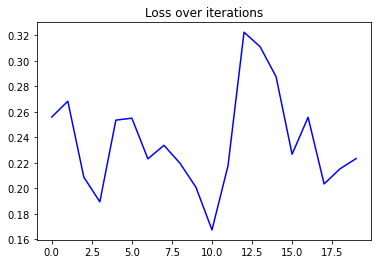

Iteration 40 - batch size: 16
Iteration 41 - batch size: 16
Current loss after 2 iterations: 0.1926242709159851


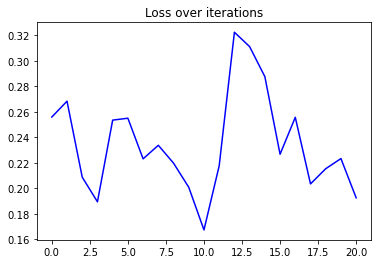

Iteration 42 - batch size: 16
Iteration 43 - batch size: 16
Current loss after 2 iterations: 0.2732885479927063


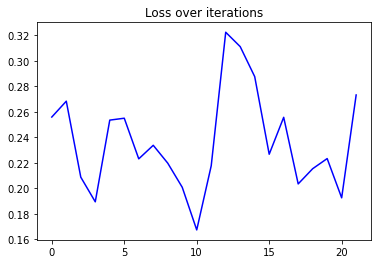

Iteration 44 - batch size: 16
Iteration 45 - batch size: 16
Current loss after 2 iterations: 0.230036199092865


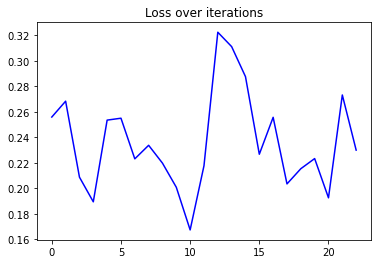

Iteration 46 - batch size: 16
Iteration 47 - batch size: 16
Current loss after 2 iterations: 0.26771265268325806


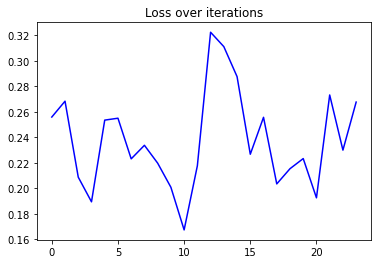

Iteration 48 - batch size: 16
Iteration 49 - batch size: 16
Current loss after 2 iterations: 0.2398914396762848


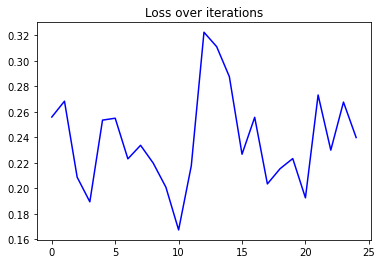

Iteration 50 - batch size: 16
Iteration 51 - batch size: 16
Current loss after 2 iterations: 0.30492690205574036


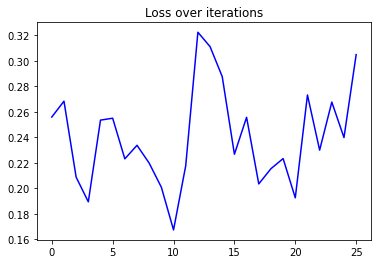

Iteration 52 - batch size: 16
Iteration 53 - batch size: 16
Current loss after 2 iterations: 0.29372090101242065


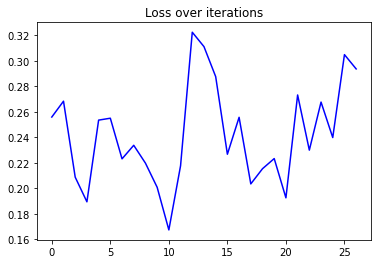

Iteration 54 - batch size: 16
Iteration 55 - batch size: 16
Current loss after 2 iterations: 0.3939288258552551


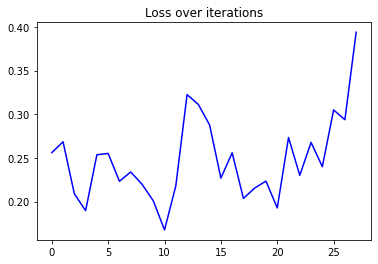

Iteration 56 - batch size: 16
Iteration 57 - batch size: 16
Current loss after 2 iterations: 0.4413352310657501


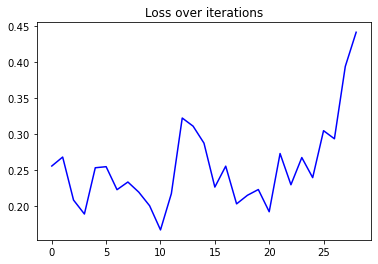

Iteration 58 - batch size: 16
Iteration 59 - batch size: 16
Current loss after 2 iterations: 0.3934403359889984


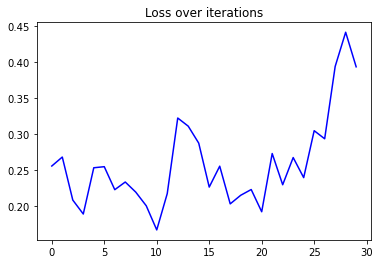

Iteration 60 - batch size: 16
Iteration 61 - batch size: 16
Current loss after 2 iterations: 0.4488898515701294


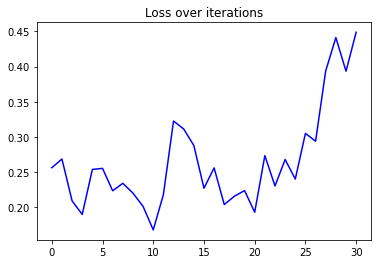

Iteration 62 - batch size: 16
Iteration 63 - batch size: 16
Current loss after 2 iterations: 0.3678799271583557


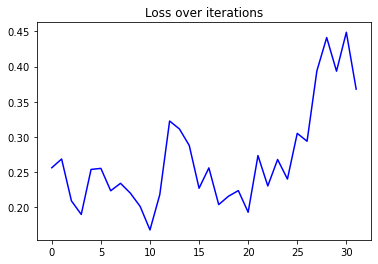

Iteration 64 - batch size: 16
Entering epoch 1
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.17652302980422974


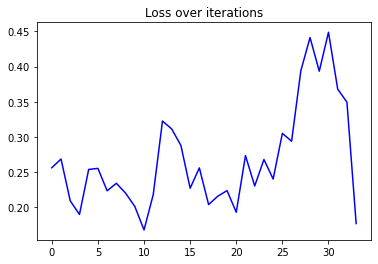

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.18304508924484253


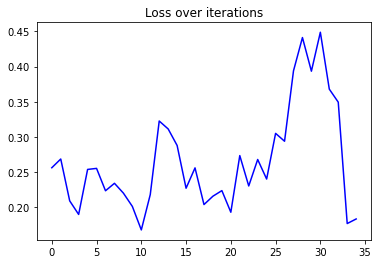

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.19229692220687866


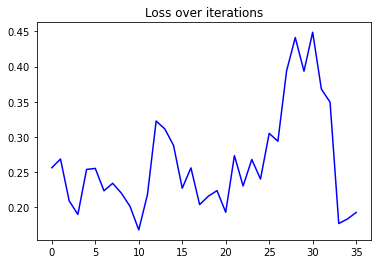

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.16890200972557068


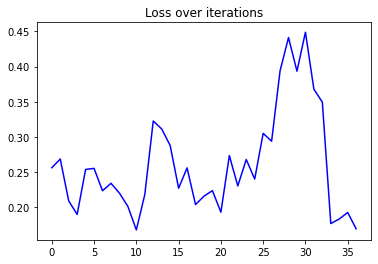

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.2495843470096588


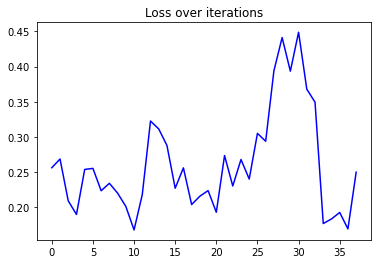

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.25226184725761414


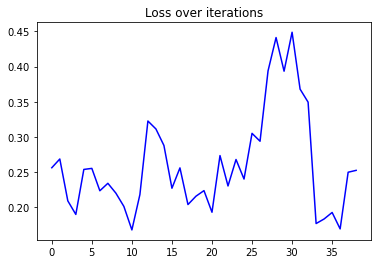

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.21950632333755493


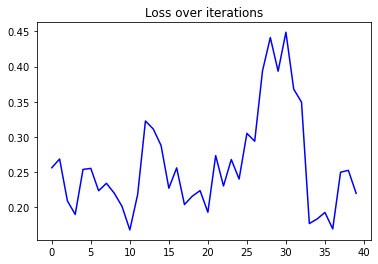

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.231281578540802


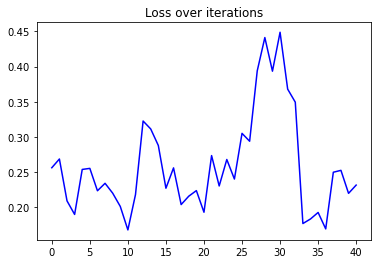

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.2173292338848114


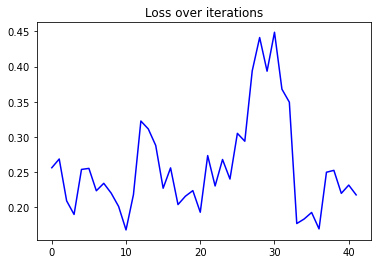

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.19811972975730896


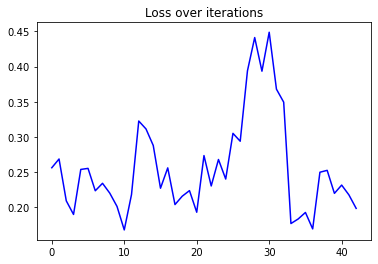

Iteration 20 - batch size: 16
Iteration 21 - batch size: 16
Current loss after 2 iterations: 0.16526728868484497


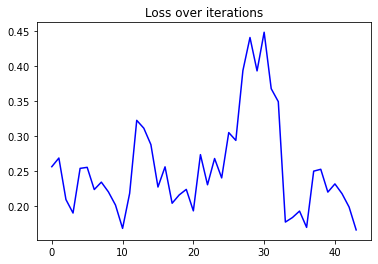

Iteration 22 - batch size: 16
Iteration 23 - batch size: 16
Current loss after 2 iterations: 0.21576246619224548


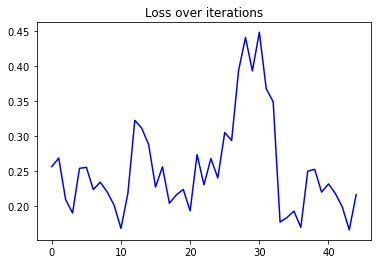

Iteration 24 - batch size: 16
Iteration 25 - batch size: 16
Current loss after 2 iterations: 0.3178706169128418


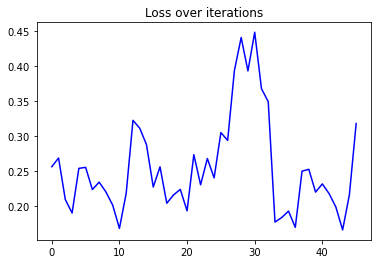

Iteration 26 - batch size: 16
Iteration 27 - batch size: 16
Current loss after 2 iterations: 0.3082942068576813


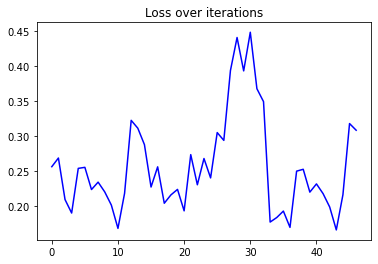

Iteration 28 - batch size: 16
Iteration 29 - batch size: 16
Current loss after 2 iterations: 0.2857809364795685


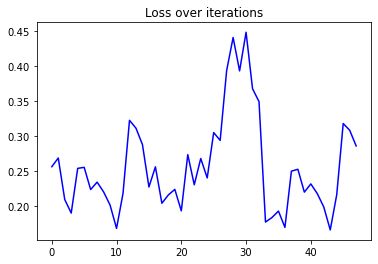

Iteration 30 - batch size: 16
Iteration 31 - batch size: 16
Current loss after 2 iterations: 0.2251322865486145


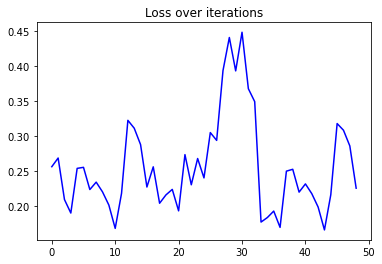

Iteration 32 - batch size: 16
Iteration 33 - batch size: 16
Current loss after 2 iterations: 0.25414565205574036


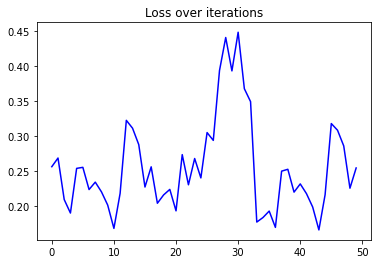

Iteration 34 - batch size: 16
Iteration 35 - batch size: 16
Current loss after 2 iterations: 0.20186293125152588


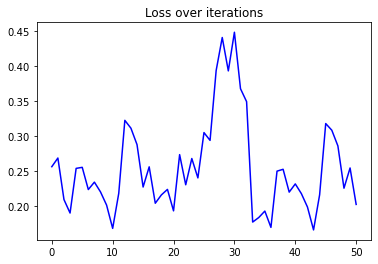

Iteration 36 - batch size: 16
Iteration 37 - batch size: 16
Current loss after 2 iterations: 0.2138516902923584


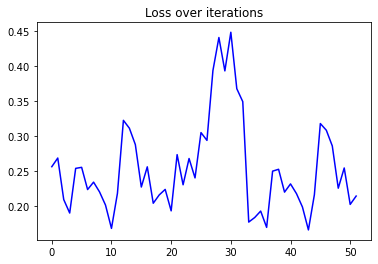

Iteration 38 - batch size: 16
Iteration 39 - batch size: 16
Current loss after 2 iterations: 0.22217953205108643


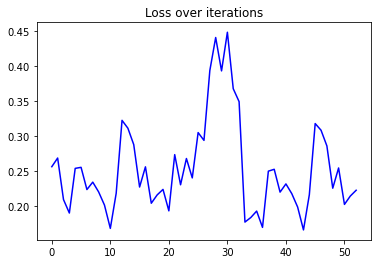

Iteration 40 - batch size: 16
Iteration 41 - batch size: 16
Current loss after 2 iterations: 0.19089403748512268


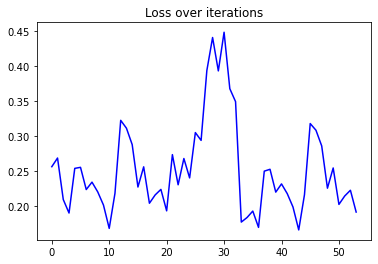

Iteration 42 - batch size: 16
Iteration 43 - batch size: 16
Current loss after 2 iterations: 0.2721303403377533


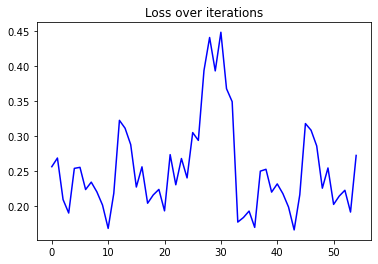

Iteration 44 - batch size: 16
Iteration 45 - batch size: 16
Current loss after 2 iterations: 0.22889286279678345


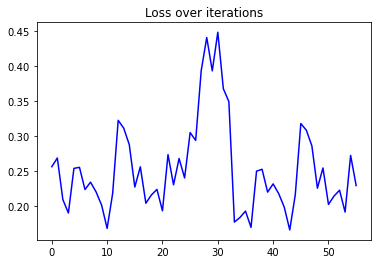

Iteration 46 - batch size: 16
Iteration 47 - batch size: 16
Current loss after 2 iterations: 0.2666495442390442


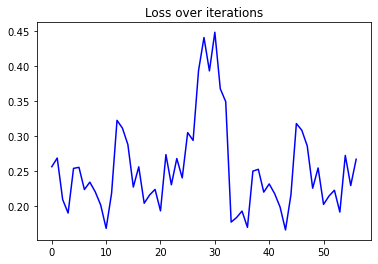

Iteration 48 - batch size: 16
Iteration 49 - batch size: 16
Current loss after 2 iterations: 0.2376742959022522


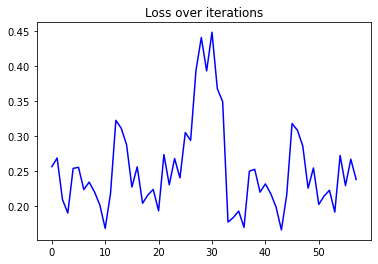

Iteration 50 - batch size: 16
Iteration 51 - batch size: 16
Current loss after 2 iterations: 0.3021383285522461


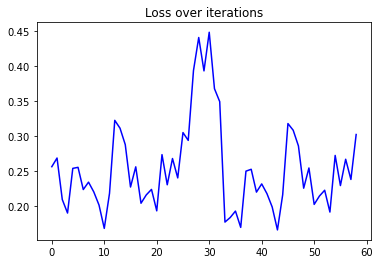

Iteration 52 - batch size: 16
Iteration 53 - batch size: 16
Current loss after 2 iterations: 0.29274052381515503


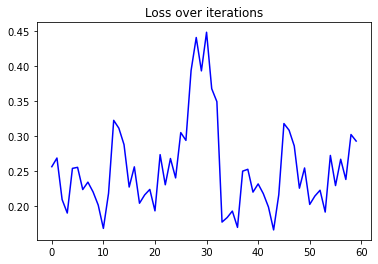

Iteration 54 - batch size: 16
Iteration 55 - batch size: 16
Current loss after 2 iterations: 0.3924907147884369


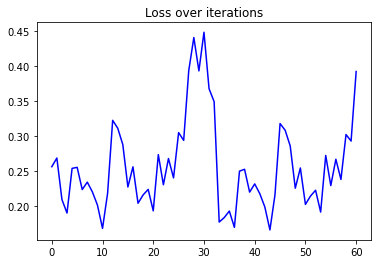

Iteration 56 - batch size: 16
Iteration 57 - batch size: 16
Current loss after 2 iterations: 0.4398074746131897


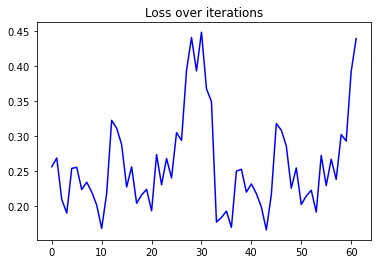

Iteration 58 - batch size: 16
Iteration 59 - batch size: 16
Current loss after 2 iterations: 0.39254629611968994


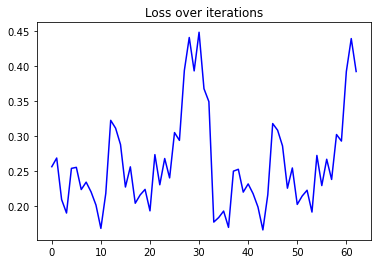

Iteration 60 - batch size: 16
Iteration 61 - batch size: 16
Current loss after 2 iterations: 0.44815441966056824


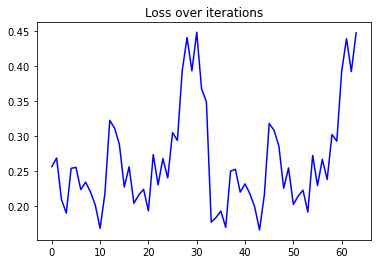

Iteration 62 - batch size: 16
Iteration 63 - batch size: 16
Current loss after 2 iterations: 0.36428749561309814


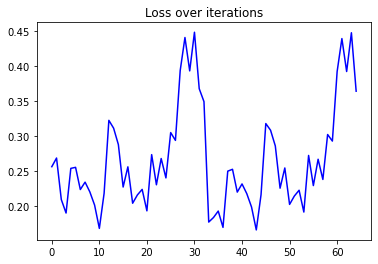

Iteration 64 - batch size: 16
Entering epoch 2
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.1756688952445984


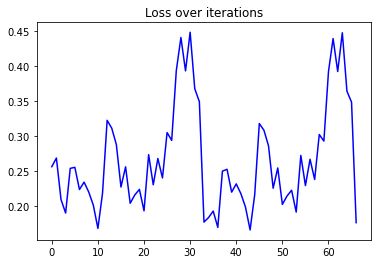

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.18217304348945618


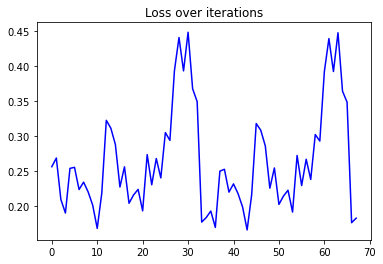

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.19149422645568848


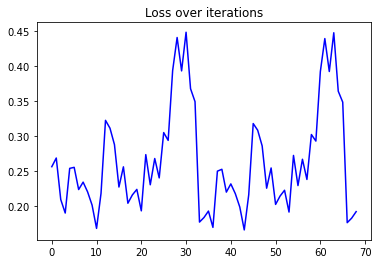

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.16805103421211243


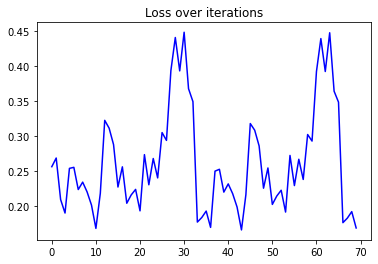

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.24894002079963684


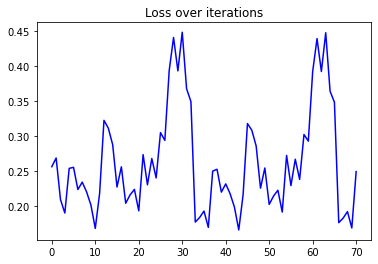

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.25157615542411804


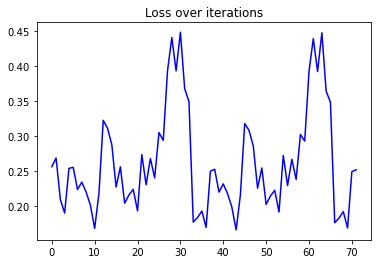

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.21870529651641846


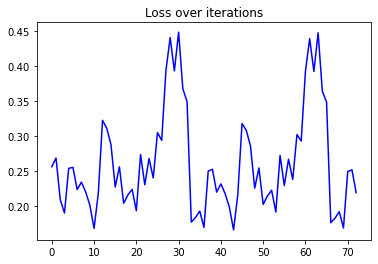

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.23062148690223694


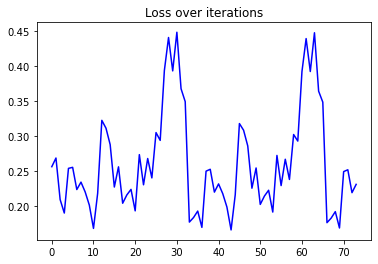

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.21668902039527893


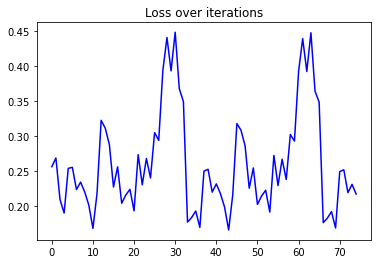

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.19747090339660645


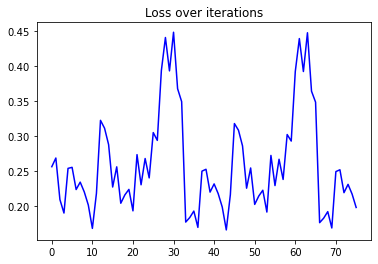

Iteration 20 - batch size: 16
Iteration 21 - batch size: 16
Current loss after 2 iterations: 0.16470199823379517


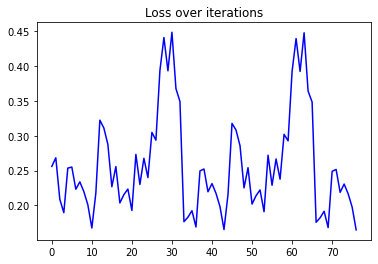

Iteration 22 - batch size: 16
Iteration 23 - batch size: 16
Current loss after 2 iterations: 0.21523001790046692


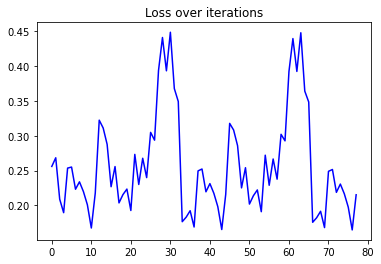

Iteration 24 - batch size: 16
Iteration 25 - batch size: 16
Current loss after 2 iterations: 0.31742405891418457


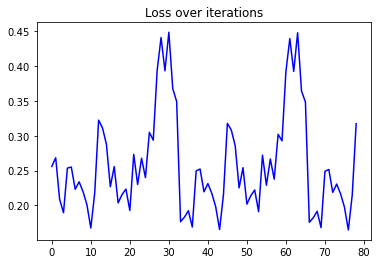

Iteration 26 - batch size: 16
Iteration 27 - batch size: 16
Current loss after 2 iterations: 0.30787405371665955


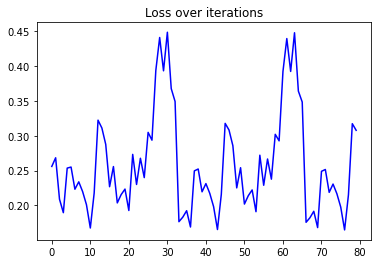

Iteration 28 - batch size: 16
Iteration 29 - batch size: 16
Current loss after 2 iterations: 0.2851412892341614


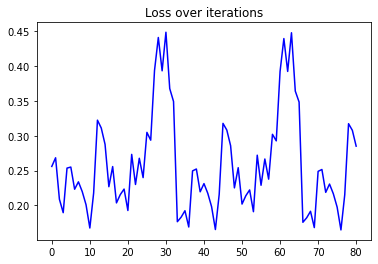

Iteration 30 - batch size: 16
Iteration 31 - batch size: 16
Current loss after 2 iterations: 0.22472989559173584


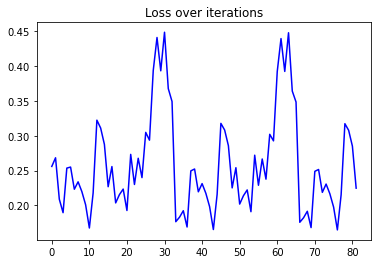

Iteration 32 - batch size: 16
Iteration 33 - batch size: 16
Current loss after 2 iterations: 0.25382399559020996


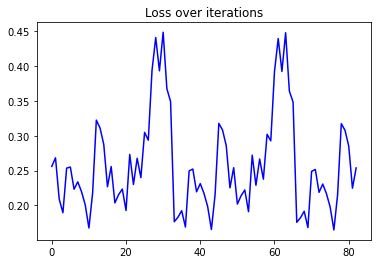

Iteration 34 - batch size: 16
Iteration 35 - batch size: 16
Current loss after 2 iterations: 0.2012864351272583


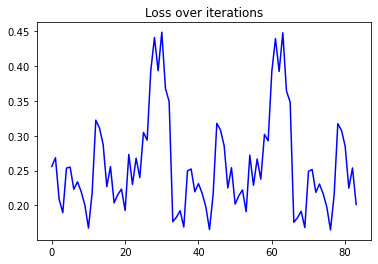

Iteration 36 - batch size: 16
Iteration 37 - batch size: 16
Current loss after 2 iterations: 0.21330568194389343


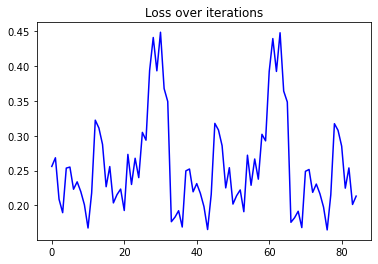

Iteration 38 - batch size: 16
Iteration 39 - batch size: 16
Current loss after 2 iterations: 0.22186866402626038


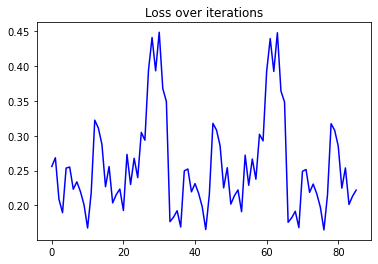

Iteration 40 - batch size: 16
Iteration 41 - batch size: 16
Current loss after 2 iterations: 0.19038093090057373


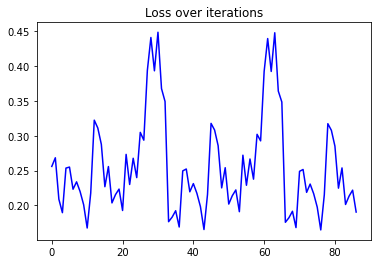

Iteration 42 - batch size: 16
Iteration 43 - batch size: 16
Current loss after 2 iterations: 0.27177900075912476


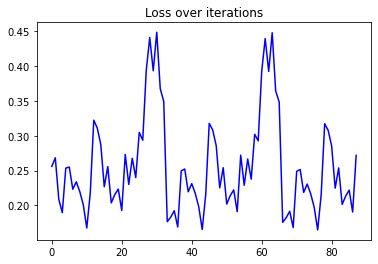

Iteration 44 - batch size: 16
Iteration 45 - batch size: 16
Current loss after 2 iterations: 0.2285560667514801


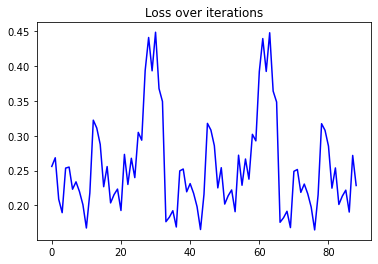

Iteration 46 - batch size: 16
Iteration 47 - batch size: 16
Current loss after 2 iterations: 0.266315758228302


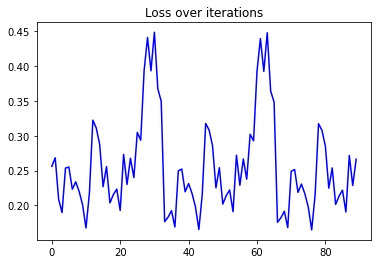

Iteration 48 - batch size: 16
Iteration 49 - batch size: 16
Current loss after 2 iterations: 0.23725658655166626


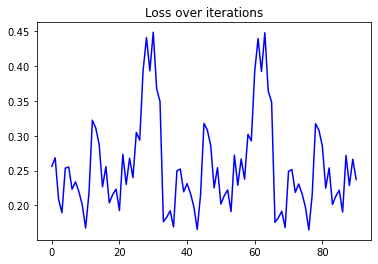

Iteration 50 - batch size: 16
Iteration 51 - batch size: 16
Current loss after 2 iterations: 0.30177727341651917


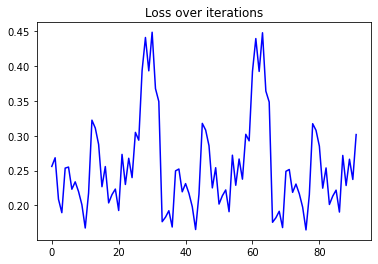

Iteration 52 - batch size: 16
Iteration 53 - batch size: 16
Current loss after 2 iterations: 0.2923772931098938


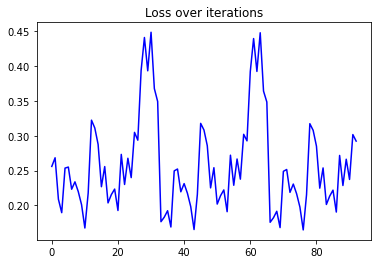

Iteration 54 - batch size: 16
Iteration 55 - batch size: 16
Current loss after 2 iterations: 0.3922586441040039


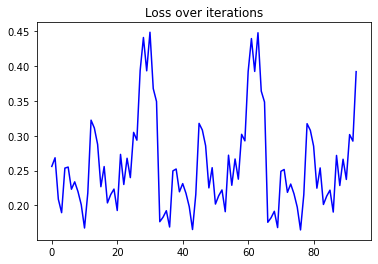

Iteration 56 - batch size: 16
Iteration 57 - batch size: 16
Current loss after 2 iterations: 0.4394407272338867


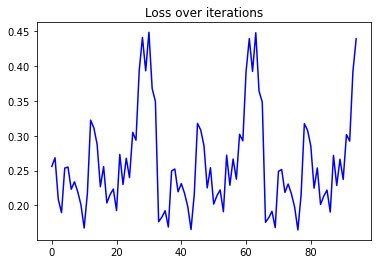

Iteration 58 - batch size: 16
Iteration 59 - batch size: 16
Current loss after 2 iterations: 0.3922431766986847


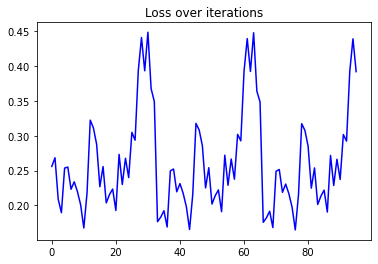

Iteration 60 - batch size: 16
Iteration 61 - batch size: 16
Current loss after 2 iterations: 0.44785404205322266


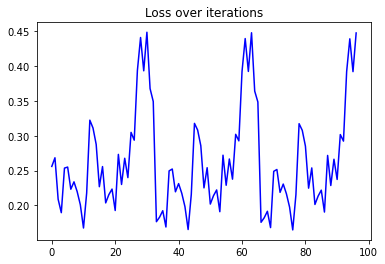

Iteration 62 - batch size: 16
Iteration 63 - batch size: 16
Current loss after 2 iterations: 0.36398422718048096


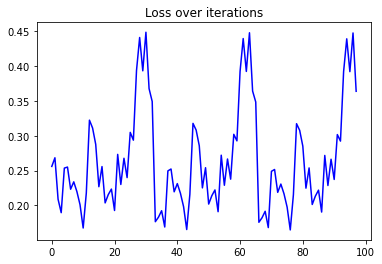

Iteration 64 - batch size: 16
Entering epoch 3
Iteration 0 - batch size: 16
Iteration 1 - batch size: 16
Current loss after 2 iterations: 0.1753179132938385


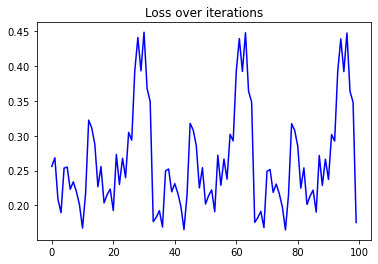

Iteration 2 - batch size: 16
Iteration 3 - batch size: 16
Current loss after 2 iterations: 0.18179625272750854


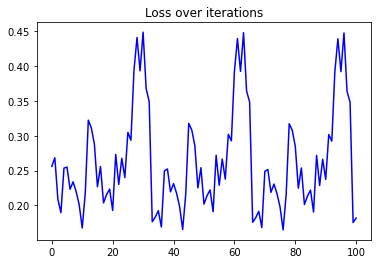

Iteration 4 - batch size: 16
Iteration 5 - batch size: 16
Current loss after 2 iterations: 0.19113105535507202


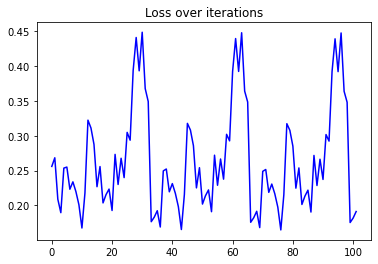

Iteration 6 - batch size: 16
Iteration 7 - batch size: 16
Current loss after 2 iterations: 0.16764986515045166


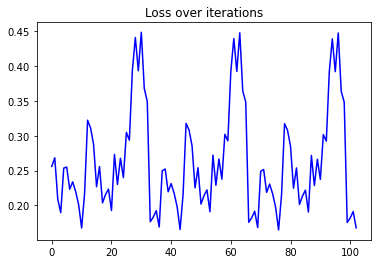

Iteration 8 - batch size: 16
Iteration 9 - batch size: 16
Current loss after 2 iterations: 0.24865224957466125


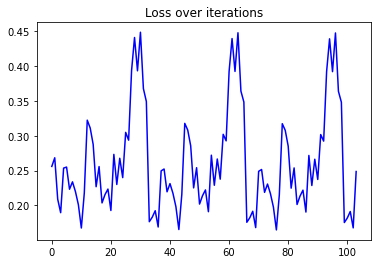

Iteration 10 - batch size: 16
Iteration 11 - batch size: 16
Current loss after 2 iterations: 0.2512202858924866


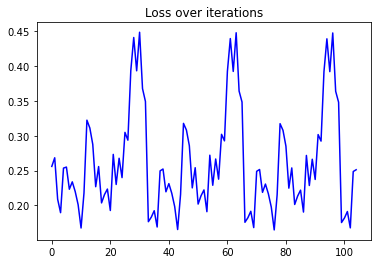

Iteration 12 - batch size: 16
Iteration 13 - batch size: 16
Current loss after 2 iterations: 0.21829217672348022


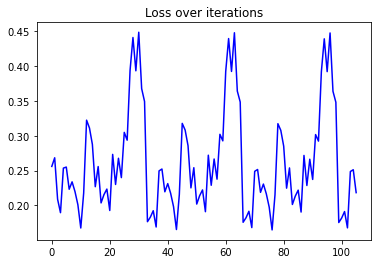

Iteration 14 - batch size: 16
Iteration 15 - batch size: 16
Current loss after 2 iterations: 0.23028528690338135


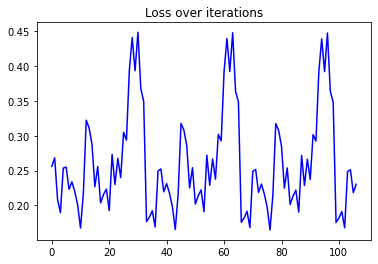

Iteration 16 - batch size: 16
Iteration 17 - batch size: 16
Current loss after 2 iterations: 0.21635550260543823


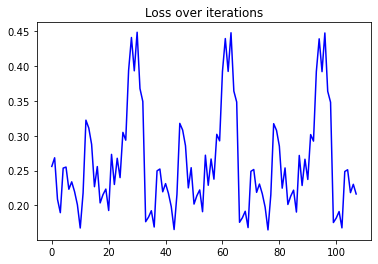

Iteration 18 - batch size: 16
Iteration 19 - batch size: 16
Current loss after 2 iterations: 0.19713425636291504


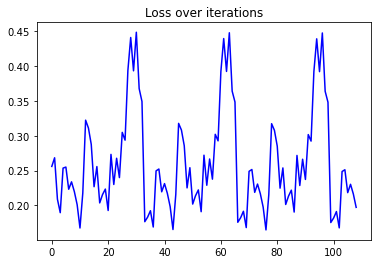

Iteration 20 - batch size: 16
Iteration 21 - batch size: 16
Current loss after 2 iterations: 0.164415180683136


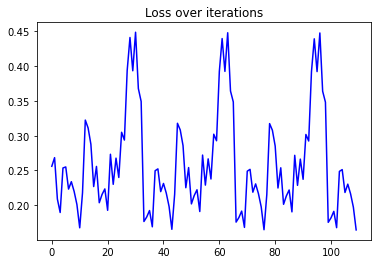

Iteration 22 - batch size: 16
Iteration 23 - batch size: 16
Current loss after 2 iterations: 0.21495017409324646


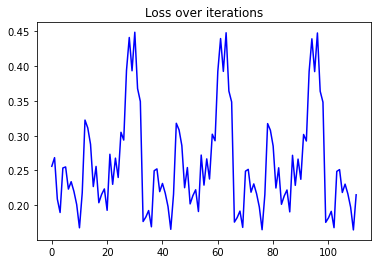

Iteration 24 - batch size: 16
Iteration 25 - batch size: 16
Current loss after 2 iterations: 0.3171817362308502


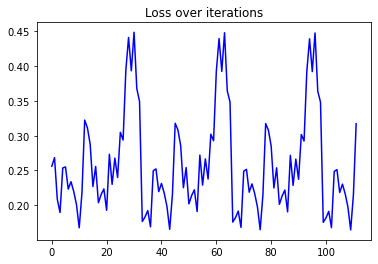

Iteration 26 - batch size: 16
Iteration 27 - batch size: 16
Current loss after 2 iterations: 0.3076312243938446


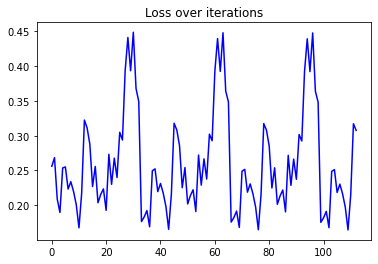

Iteration 28 - batch size: 16
Iteration 29 - batch size: 16
Current loss after 2 iterations: 0.2847517132759094


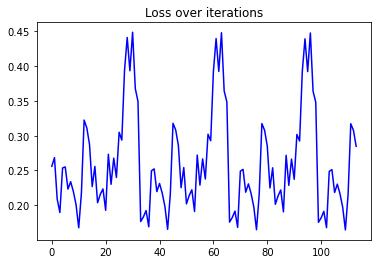

Iteration 30 - batch size: 16
Iteration 31 - batch size: 16
Current loss after 2 iterations: 0.22448715567588806


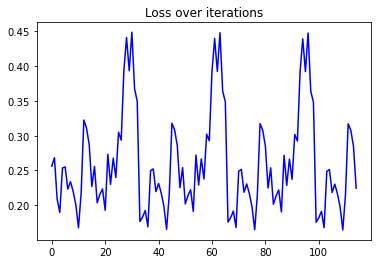

Iteration 32 - batch size: 16
Iteration 33 - batch size: 16
Current loss after 2 iterations: 0.25364241003990173


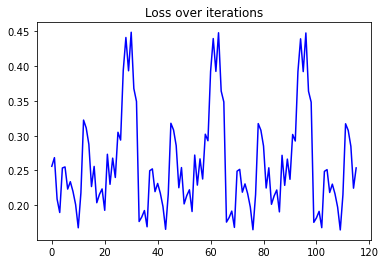

Iteration 34 - batch size: 16
Iteration 35 - batch size: 16
Current loss after 2 iterations: 0.20092317461967468


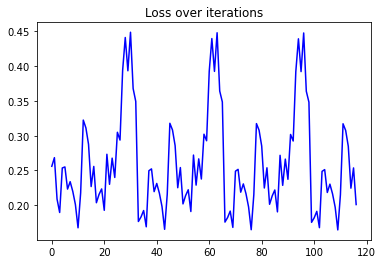

Iteration 36 - batch size: 16
Iteration 37 - batch size: 16
Current loss after 2 iterations: 0.2129586935043335


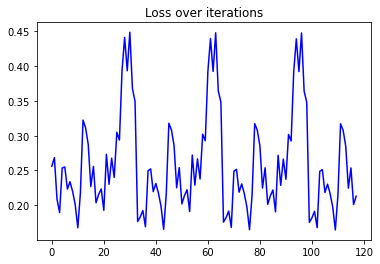

Iteration 38 - batch size: 16
Iteration 39 - batch size: 16
Current loss after 2 iterations: 0.22167104482650757


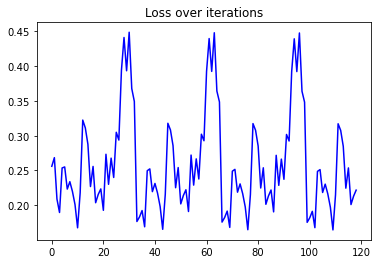

Iteration 40 - batch size: 16
Iteration 41 - batch size: 16
Current loss after 2 iterations: 0.19004446268081665


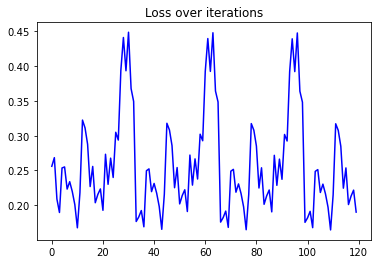

Iteration 42 - batch size: 16
Iteration 43 - batch size: 16
Current loss after 2 iterations: 0.2715543508529663


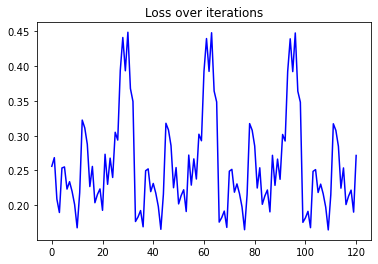

Iteration 44 - batch size: 16
Iteration 45 - batch size: 16
Current loss after 2 iterations: 0.2283252477645874


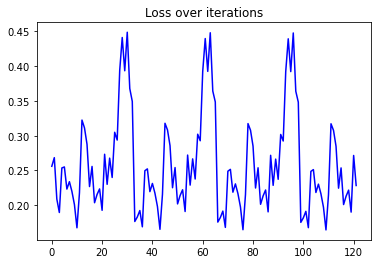

Iteration 46 - batch size: 16
Iteration 47 - batch size: 16
Current loss after 2 iterations: 0.26609960198402405


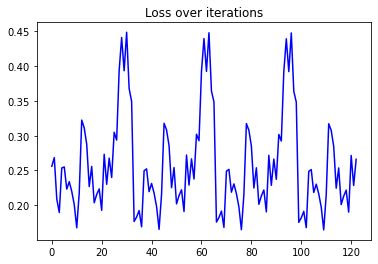

Iteration 48 - batch size: 16
Iteration 49 - batch size: 16
Current loss after 2 iterations: 0.23696693778038025


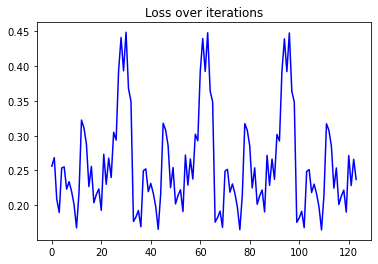

Iteration 50 - batch size: 16
Iteration 51 - batch size: 16
Current loss after 2 iterations: 0.30151766538619995


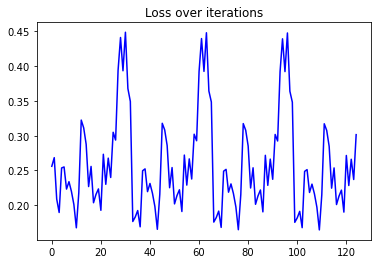

Iteration 52 - batch size: 16
Iteration 53 - batch size: 16
Current loss after 2 iterations: 0.2921285927295685


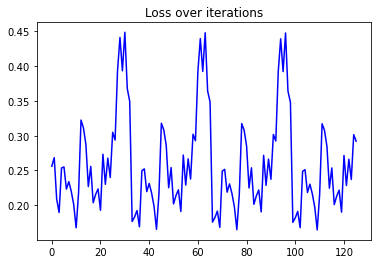

Iteration 54 - batch size: 16
Iteration 55 - batch size: 16
Current loss after 2 iterations: 0.3920932710170746


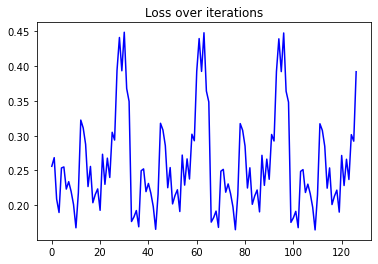

Iteration 56 - batch size: 16
Iteration 57 - batch size: 16
Current loss after 2 iterations: 0.4391808807849884


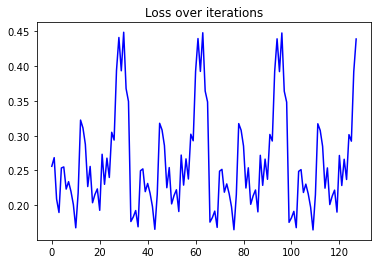

Iteration 58 - batch size: 16
Iteration 59 - batch size: 16
Current loss after 2 iterations: 0.39202287793159485


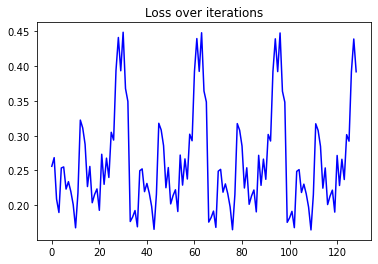

Iteration 60 - batch size: 16
Iteration 61 - batch size: 16
Current loss after 2 iterations: 0.4476398527622223


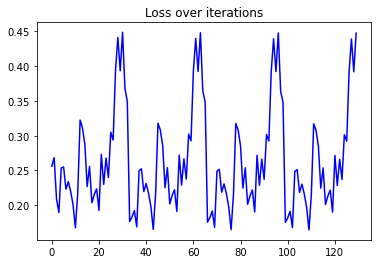

Iteration 62 - batch size: 16
Iteration 63 - batch size: 16
Current loss after 2 iterations: 0.3637567162513733


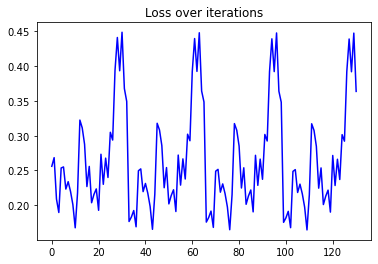

Iteration 64 - batch size: 16
Entering epoch 4


KeyboardInterrupt: 

In [12]:
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

#### Lets see the results


In [ ]:
for i, (coords, features, targets) in enumerate(cl_dataset):
    if i == 3:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()